# KNN for Hand Pose Classification

K-nearest neighbors algorithm to classify multiple hand poses
* Dataset of poses available as multiple .csv files
* Each file contains poses for a different class 
* Each file name is use as the label for that class

In [1]:
!pip install numpy==1.19.3
!pip install mediapipe

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas
import os
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/Colab Notebooks/Deep Learning/KNN_Pose_Classification/handpose_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [4]:
def load_pose_samples(pose_samples_folder, file_extension='csv'):
    """ Loads pose samples from a given folder."""

    # Each file in the folder represents one pose class.
    file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

    pose_samples = []
    class_samples = []
    for file_name in file_names:
        # Use file name as pose class name.
        class_name = file_name[:-(len(file_extension) + 1)]

        # Parse CSV.
        with open(os.path.join(pose_samples_folder, file_name)) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                landmarks = np.array(row[:], np.float32).reshape(21, 3)
                landmarks = landmarks[:, :2].reshape((42,))                     # use only 2d data
                pose_samples.append(landmarks)
                class_samples.append(class_name)
    return pose_samples, class_samples
    #return np.asarray(pose_samples), np.asarray(class_samples)

In [5]:
x, y = load_pose_samples(data_dir)                                              # x: list with all instances as ndarray (42,) y: list with labels

## Draw Hand Landmarks

In [6]:
import math
from typing import List, Tuple, Union
import cv2
import mediapipe as mp


def _normalized_to_pixel_coordinates(normalized_x: float, normalized_y: float, image_width: int, image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and is_valid_normalized_value(normalized_y)):
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def draw_landmarks(image: np.ndarray, landmarks: np.ndarray, connections: List[Tuple[int, int]] = None):
  """Draws the landmarks and the connections on the image.
  Args:
    image: A three channel RGB image represented as numpy ndarray.
    landmarks: A normalized landmark numpy array 
    connections: A list of landmark index tuples that specifies how landmarks to be connected in the drawing.
  Raises:
    ValueError: If one of the followings:
      a) If the input image is not three channel RGB.
      b) If any connetions contain invalid landmark index.
  """
  if image.shape[2] != 3:
    raise ValueError('Input image must contain three channel rgb data.')
  image_rows, image_cols, _ = image.shape
  idx_to_coordinates = {}
  for idx in range(21):
    landmark_px = _normalized_to_pixel_coordinates(landmarks[2*idx], landmarks[2*idx+1], image_cols, image_rows)
    if landmark_px:
      idx_to_coordinates[idx] = landmark_px
  if connections:
    num_landmarks = 21
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
        cv2.line(image, idx_to_coordinates[start_idx], idx_to_coordinates[end_idx], (0, 255, 0), 2)
  
  # Draws landmark points after finishing the connection lines, which is aesthetically better.
  for landmark_px in idx_to_coordinates.values():
    cv2.circle(image, landmark_px, 2, (255, 0, 0), 2)

In [7]:
hand_connections = mp.solutions.hands.HAND_CONNECTIONS

def plot_random_pose(features, labels, indexes):
  plt.figure(figsize=(15, 15))
  for i in range(25):
    img = np.zeros((200, 200, 3), dtype = "uint8")
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    hand_landmarks = features[indexes[i]]
    draw_landmarks(img, hand_landmarks, hand_connections)
    plt.imshow(img)
    plt.xlabel(labels[indexes[i]])
plt.show()

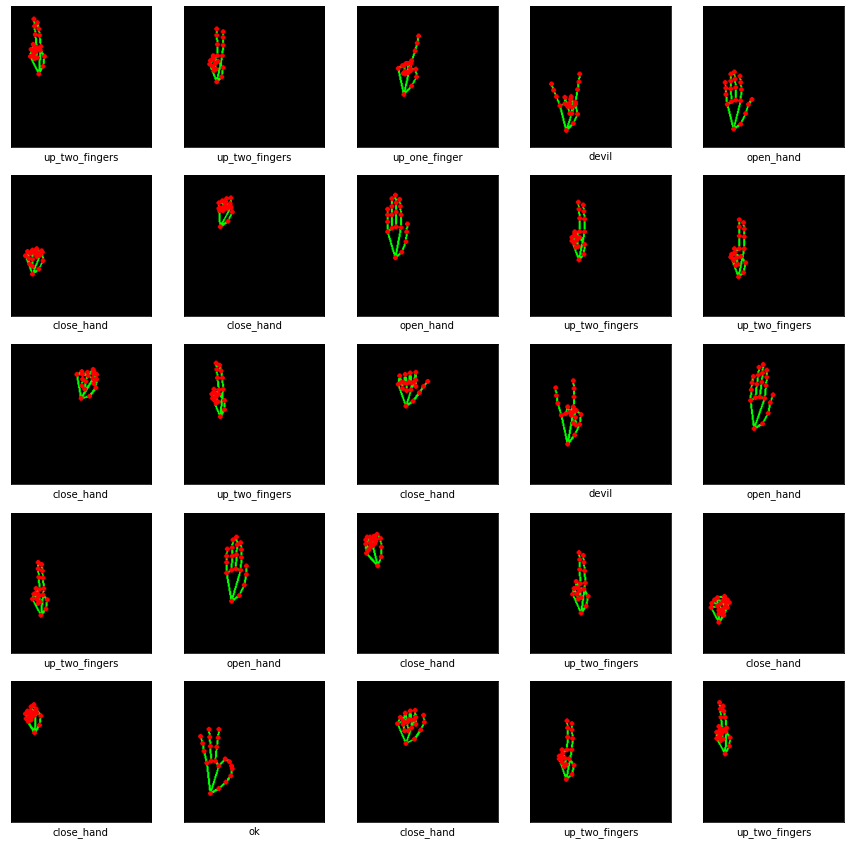

In [8]:
plot_random_pose(x,y, np.random.randint(len(y), size=25))

## Hand Pose Embedding

In [9]:
class HandPoseEmbedder(object):
    """Converts 2D pose landmarks into 2D embedding."""

    def __init__(self):
        # Names of the landmarks as they appear in the prediction.
        self._landmark_names = [
            'WRIST',
            'THUMB_CMC','THUMB_MCP','THUMB_IP','THUMB_TIP',
            'INDEX_FINGER_MCP','INDEX_FINGER_PIP','INDEX_FINGER_DIP','INDEX_FINGER_TIP',
            'MIDDLE_FINGER_MCP','MIDDLE_FINGER_PIP','MIDDLE_FINGER_DIP','MIDDLE_FINGER_TIP',
            'RING_FINGER_MCP','RING_FINGER_PIP','RING_FINGER_DIP','RING_FINGER_TIP',
            'PINKY_MCP','PINKY_PIP','PINKY_DIP','PINKY_TIP',
        ]

    def __call__(self, landmarks):
        """Converts pose landmarks to embedding

        Args:
          landmarks - NumPy array with 2D landmarks of shape (N, 2).

        Result:
          Numpy array with pose embedding of shape (M, 2) where M is the number of
          pairwise distances defined in `_get_pose_distance_embedding`.
        """
        
        landmarks = landmarks.reshape(21,2)                                     # Get pose landmarks as 2D points
        embedding = self._get_pose_distance_embedding(landmarks)                # Get embedding....
        return embedding.flatten()                                              # as a row vector

    def _get_pose_distance_embedding(self, landmarks):
        """Converts pose landmarks into 2D embedding.

        We use several pairwise 2D distances to form pose embedding. All distances
        include X and Y components with sign. We differnt types of pairs to cover
        different pose classes. Feel free to remove some or add new.

        Args:
          landmarks - NumPy array with 2D landmarks of shape (N, 2).

        Result:
          Numpy array with pose embedding of shape (M, 2) where M is the number of
          pairwise distances.
        """
        embedding = np.array([
            # One joint.
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'THUMB_MCP'),
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'INDEX_FINGER_MCP'),
            self._get_distance_by_names(landmarks, 'MIDDLE_FINGER_TIP', 'MIDDLE_FINGER_MCP'),
            self._get_distance_by_names(landmarks, 'RING_FINGER_TIP', 'RING_FINGER_MCP'),
            self._get_distance_by_names(landmarks, 'PINKY_TIP', 'PINKY_MCP'),

            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'THUMB_IP'),
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'INDEX_FINGER_PIP'),
            self._get_distance_by_names(landmarks, 'MIDDLE_FINGER_TIP', 'MIDDLE_FINGER_PIP'),
            self._get_distance_by_names(landmarks, 'RING_FINGER_TIP', 'RING_FINGER_PIP'),
            self._get_distance_by_names(landmarks, 'PINKY_TIP', 'PINKY_PIP'),

            # Two joints.
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'INDEX_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'MIDDLE_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'RING_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'PINKY_TIP'),
            
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'MIDDLE_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'RING_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'INDEX_FINGER_TIP', 'PINKY_TIP'),
            
            self._get_distance_by_names(landmarks, 'MIDDLE_FINGER_TIP', 'RING_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'MIDDLE_FINGER_TIP', 'PINKY_TIP'),

            self._get_distance_by_names(landmarks, 'RING_FINGER_TIP', 'PINKY_TIP'),

            # Four joints.
            self._get_distance_by_names(landmarks, 'WRIST', 'INDEX_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'WRIST', 'MIDDLE_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'WRIST', 'RING_FINGER_TIP'),
            self._get_distance_by_names(landmarks, 'WRIST', 'PINKY_TIP'),

            # Five joints.
            self._get_distance_by_names(landmarks, 'THUMB_TIP', 'MIDDLE_FINGER_MCP'),

        ])

        return embedding

    def _get_distance_by_names(self, landmarks, name_from, name_to):
        lmk_from = landmarks[self._landmark_names.index(name_from)]
        lmk_to = landmarks[self._landmark_names.index(name_to)]
        return self._get_distance(lmk_from, lmk_to)

    def _get_distance(self, lmk_from, lmk_to):
        return lmk_to - lmk_from


In [10]:
# Initialize embedder.
pose_embedder = HandPoseEmbedder()
x_embedding = [pose_embedder(instance) for instance in x]
x_embedding = np.asarray(x_embedding)

## Data Preparation

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_embedding, y, random_state=0, test_size=0.2)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
print(label_encoder.classes_)

['close_hand' 'devil' 'ok' 'open_hand' 'up_one_finger' 'up_two_fingers']


## Classification

In [14]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=11)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

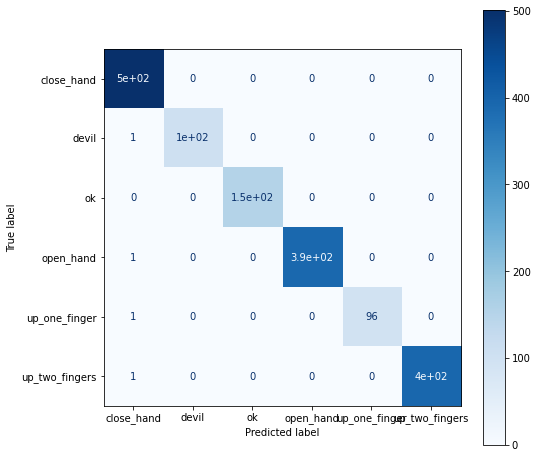

[[501   0   0   0   0   0]
 [  1 104   0   0   0   0]
 [  0   0 153   0   0   0]
 [  1   0   0 393   0   0]
 [  1   0   0   0  96   0]
 [  1   0   0   0   0 395]]


In [15]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plt.figure(figsize=(8, 8))
disp = plot_confusion_matrix(classifier, X_test, y_test, display_labels=label_encoder.classes_, cmap=plt.cm.Blues, ax=plt.gca())
plt.show()
print(disp.confusion_matrix)